In [9]:
!pip install transformers

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Ryan.Models.LSTM_model_Regression.preprocess import preprocess_data
from Ryan.Models.LSTM_model_Regression.lstm_models import  LSTMModel, LSTMModel_multi
from Ryan.Models.LSTM_model_Regression.run_fn import eval_fn, train_fn
from Ryan.Models.LSTM_model_Regression.load_data import load_data, create_sequences
from Ryan.Models.LSTM_model_Regression.load_data import load_data2
import torch
from transformers import get_linear_schedule_with_warmup
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

ImportError: cannot import name 'get_linear_schedule_with_warmup' from 'transformers' (D:\anaconda\Lib\site-packages\transformers\__init__.py)

In [16]:
lob_data=pd.read_csv('resampled_lob_secs2.csv')

loaded_pred=np.load('./saved_models_regression/predictions_new3.npy')
loaded_true=np.load('./saved_models_regression/actuals_new3.npy')
loaded_pred_adjusted=loaded_pred-14

In [17]:
# This is only for trading volume, not for modeling
# # 设置一个时间窗口
rolling_window = 20  # 例如，我们使用过去5个时间点的数据来计算波动率

# 计算对数收益率 shift(1)是为了计算相对于前一分钟的收益率
lob_data['Log Return Max Bid'] = np.log(lob_data['Max Bid Price'] / lob_data['Max Bid Price'].shift(1))
lob_data['Log Return Min Ask'] = np.log(lob_data['Min Ask Price'] / lob_data['Min Ask Price'].shift(1))

# 计算滚动标准差作为波动率的度量
lob_data['Volatility Max Bid'] = lob_data['Log Return Max Bid'].rolling(window=rolling_window).std()
lob_data['Volatility Min Ask'] = lob_data['Log Return Min Ask'].rolling(window=rolling_window).std()

# 由于滚动计算会产生缺失值，我们通常会删除这些值
# lob_data.dropna(inplace=True)

# Trading volume
def adjust_trade_quantity(volatility, max_tradeable_quantity, base_quantity=1, risk_tolerance=0.5, scaler_factor=10):
    """
    根据波动率和最大可交易量调整交易量。
    volatility: 当前波动率
    max_tradeable_quantity: 该时间点的最大可交易量（对于买入操作，是Min Ask Quantity；对于卖出操作，是Max Bid Quantity）
    base_quantity: 基础交易量
    risk_tolerance: 风险容忍度，取值范围为[0, 1]，数值越小表风险承受越大，交易量越大
    scaler_factor: 缩放因子，用于进一步调整基于波动率的交易量
    """
    # 确保风险容忍度和波动率不会导致除以0
    if volatility <= 0.0001:
        volatility = 0.0001
    if risk_tolerance <= 0:
        risk_tolerance = 0.1  # 设置一个默认的风险容忍度，避免除以0

    # 基于波动率调整的交易量
    adjusted_quantity = base_quantity / (volatility * risk_tolerance * scaler_factor)
    adjusted_quantity = max(1, round(adjusted_quantity))  # 确保至少交易1单位，并且是整数

    # 确保交易量不超过最大可交易量
    final_trade_quantity = min(adjusted_quantity, max_tradeable_quantity)

    return final_trade_quantity

In [18]:
# short term EMA
ema_short = lob_data['price'].ewm(span=20, adjust=False).mean()
# long term EMA
ema_long = lob_data['price'].ewm(span=40, adjust=False).mean()
# MACD line
macd = ema_short - ema_long
# signal line
signal = macd.ewm(span=10, adjust=False).mean()
# histogram
histogram = macd - signal

# 把计算出的MACD指标添加到dataframe
lob_data['MACD Line'] = macd
lob_data['MACD Signal'] = signal
lob_data['MACD Histogram'] = histogram

In [19]:
## generate signal based on MACD
# 通过比较MACD线和信号线的前后值来确定交叉
lob_data['MACD Trade Signal'] = 0
lob_data.loc[(lob_data['MACD Line'] > lob_data['MACD Signal']) &  # MACD线上穿信号线
       (lob_data['MACD Line'].shift(1) <= lob_data['MACD Signal'].shift(1)), 'MACD Trade Signal'] = 1
lob_data.loc[(lob_data['MACD Line'] < lob_data['MACD Signal']) &  # MACD线下穿信号线
       (lob_data['MACD Line'].shift(1) >= lob_data['MACD Signal'].shift(1)), 'MACD Trade Signal'] = -1

In [20]:
lob_data['MACD Trade Signal'].value_counts()

 0    3432280
-1     167502
 1     167502
Name: MACD Trade Signal, dtype: int64

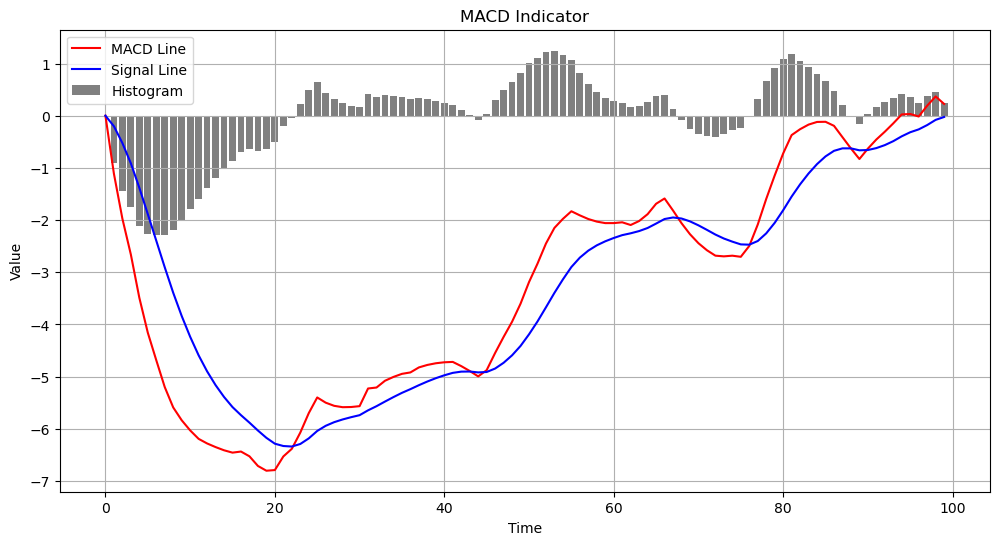

In [21]:
# 绘制macd和signal柱状图
plt.figure(figsize=(12, 6))
plt.plot(lob_data['MACD Line'][:100], label='MACD Line', color='red')
plt.plot(lob_data['MACD Signal'][:100], label='Signal Line', color='blue')
plt.bar(lob_data.index[:100], lob_data['MACD Histogram'][:100], label='Histogram', color='grey')
plt.legend()
plt.title('MACD Indicator')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [22]:
split_index=int(0.9*len(lob_data))
train_data=lob_data.iloc[:split_index]
test_data=lob_data.iloc[split_index:]
test_set=test_data[21:-1]

test_set

,Datetime,Min Ask Price,Max Bid Price,price,Total Bid Quantity,Total Ask Quantity,Min Ask Quantity,Max Bid Quantity,ofi,RSI,MA,Momentum,Log Return Max Bid,Log Return Min Ask,Volatility Max Bid,Volatility Min Ask,MACD Line,MACD Signal,MACD Histogram,MACD Trade Signal
3390576,2025-06-13 04:28:47,256,109,193.000000,30,17,4,3,-7,56.384379,229.600000,83.142857,-0.027151,0.508225,0.019517,0.525209,15.288718,7.223871,8.064847,0
3390577,2025-06-13 04:28:48,274,112,184.000000,30,17,4,5,1,55.606061,244.400000,74.000000,0.027151,0.067951,0.016378,0.521311,15.321761,8.696215,6.625546,0
3390578,2025-06-13 04:28:49,390,110,196.153846,39,17,4,9,-13,39.854729,224.630769,-98.846154,-0.018019,0.353019,0.016768,0.486226,15.843655,9.995749,5.847906,0
3390579,2025-06-13 04:28:50,207,109,126.818182,39,16,2,9,-7,16.606580,166.594406,-290.181818,-0.009132,-0.633428,0.016816,0.509797,12.998037,10.541620,2.456417,0
3390580,2025-06-13 04:28:51,156,109,117.545455,39,17,2,9,2,45.163267,163.503497,-15.454545,0.000000,-0.282863,0.016816,0.514272,10.057846,10.453661,-0.395815,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767278,2025-07-01 08:17:54,169,109,139.000000,15,18,2,2,4,88.284519,117.257143,45.750000,0.086178,-0.226688,0.132342,0.252994,-11.984049,-12.782929,0.798880,1
3767279,2025-07-01 08:17:55,183,109,133.666667,21,18,1,2,-1,79.558011,124.390476,35.666667,0.000000,0.079587,0.132342,0.253520,-10.756219,-12.414436,1.658217,0
3767280,2025-07-01 08:17:56,183,110,128.250000,24,18,1,3,3,81.702128,131.840476,37.250000,0.009132,0.000000,0.132352,0.253479,-9.901191,-11.957482,2.056292,0
3767281,2025-07-01 08:17:57,123,110,114.333333,26,18,1,2,0,34.012739,129.450000,-11.952381,0.000000,-0.397302,0.132327,0.269303,-9.765866,-11.559007,1.793140,0


In [168]:
# # 对price列进行归一化
# scaler = MinMaxScaler()
# train_data['price'] = scaler.fit_transform(train_data['price'].values.reshape(-1, 1))
# test_set['price'] = scaler.transform(test_set['price'].values.reshape(-1, 1))
# 
# test_set

In [83]:
# def reverse_min_max(normalized_data, min_value=9.642857142857142, max_value=717.8333333333334):
#     return normalized_data * (max_value - min_value) + min_value
# 
# def min_max_normalize(data, min_value=9.642857142857142, max_value=717.8333333333334):
#     return (data - min_value) / (max_value - min_value)
# 
# pred_scaled=min_max_normalize(loaded_pred_adjusted)

In [23]:
test_df=test_set.reset_index()
test_df

,index,Datetime,Min Ask Price,Max Bid Price,price,Total Bid Quantity,Total Ask Quantity,Min Ask Quantity,Max Bid Quantity,ofi,...,MA,Momentum,Log Return Max Bid,Log Return Min Ask,Volatility Max Bid,Volatility Min Ask,MACD Line,MACD Signal,MACD Histogram,MACD Trade Signal
0,3390576,2025-06-13 04:28:47,256,109,193.000000,30,17,4,3,-7,...,229.600000,83.142857,-0.027151,0.508225,0.019517,0.525209,15.288718,7.223871,8.064847,0
1,3390577,2025-06-13 04:28:48,274,112,184.000000,30,17,4,5,1,...,244.400000,74.000000,0.027151,0.067951,0.016378,0.521311,15.321761,8.696215,6.625546,0
2,3390578,2025-06-13 04:28:49,390,110,196.153846,39,17,4,9,-13,...,224.630769,-98.846154,-0.018019,0.353019,0.016768,0.486226,15.843655,9.995749,5.847906,0
3,3390579,2025-06-13 04:28:50,207,109,126.818182,39,16,2,9,-7,...,166.594406,-290.181818,-0.009132,-0.633428,0.016816,0.509797,12.998037,10.541620,2.456417,0
4,3390580,2025-06-13 04:28:51,156,109,117.545455,39,17,2,9,2,...,163.503497,-15.454545,0.000000,-0.282863,0.016816,0.514272,10.057846,10.453661,-0.395815,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376702,3767278,2025-07-01 08:17:54,169,109,139.000000,15,18,2,2,4,...,117.257143,45.750000,0.086178,-0.226688,0.132342,0.252994,-11.984049,-12.782929,0.798880,1
376703,3767279,2025-07-01 08:17:55,183,109,133.666667,21,18,1,2,-1,...,124.390476,35.666667,0.000000,0.079587,0.132342,0.253520,-10.756219,-12.414436,1.658217,0
376704,3767280,2025-07-01 08:17:56,183,110,128.250000,24,18,1,3,3,...,131.840476,37.250000,0.009132,0.000000,0.132352,0.253479,-9.901191,-11.957482,2.056292,0
376705,3767281,2025-07-01 08:17:57,123,110,114.333333,26,18,1,2,0,...,129.450000,-11.952381,0.000000,-0.397302,0.132327,0.269303,-9.765866,-11.559007,1.793140,0


In [24]:
# 截取一部分测试数据
sample_set = test_df[(test_df['Datetime'] >= '2025-06-23 00:00:00') & (test_df['Datetime'] <= '2025-06-23 23:59:59')]

start_of_trade = sample_set.index[0]
end_of_trade = sample_set.index[-1]
len(sample_set), start_of_trade, end_of_trade

(30438, 164894, 195331)

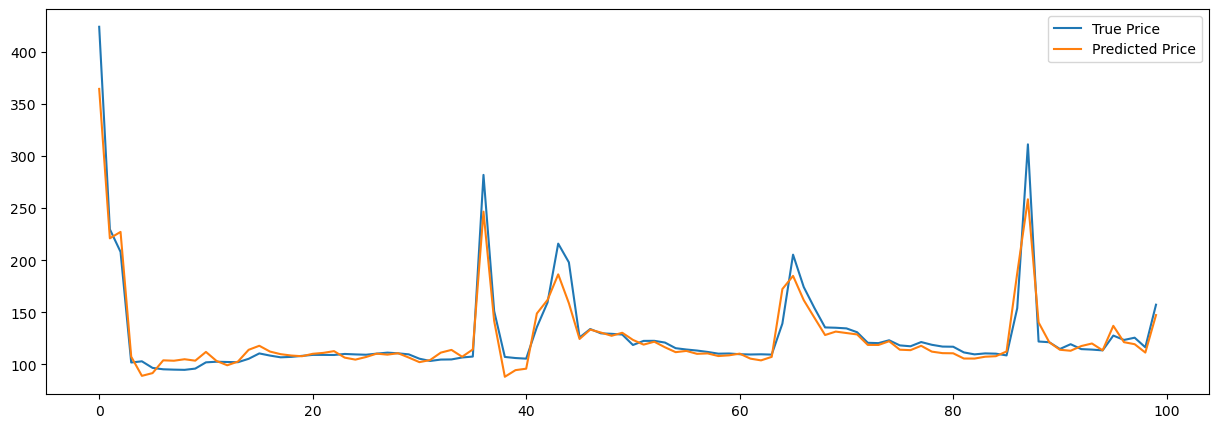

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(sample_set['price'][:100].values, label='True Price')
plt.plot(loaded_pred_adjusted[start_of_trade:start_of_trade+100], label='Predicted Price')
plt.legend()

In [26]:
initial_capital = 10000
capital = initial_capital
has_position = False
trade_log = []
# capital_history = [initial_capital]
current_holdings = 0
transaction_cost = 0.005
# trade_quantity = 1

len_of_trade = len(sample_set)
count = 0

# loaded_pred_adjusted = pred_scaled

for i in range(len_of_trade-1):
    # skip the iteration if there is any missing value
    # if test_set.iloc[i+start_of_trade].isna().any():
    #     continue
        
    if current_holdings > 0:
            has_position = True
    else:
        has_position = False
        
    count += 1
    
    # if capital is less than 50% of the initial capital, stop trading
    # if capital <= 0.5*initial_capital:
    #     print('Capital is less than 50% of the initial capital, stop trading.')
    #     break
    
    current_true = sample_set['price'].iloc[i] # current true price
    current_predict = loaded_pred_adjusted[i+start_of_trade] # current predicted price
    next_predict = loaded_pred_adjusted[i+1+start_of_trade] # next predicted price
    
    # adjust the trade quantity based on the volatility. make the trade quantity no more than the max tradeable quantity
    current_volatility_buy = sample_set['Volatility Min Ask'].iloc[i ]
    current_volatility_sell = sample_set['Volatility Max Bid'].iloc[i ]
    
    # get other indicators
    ofi = sample_set['ofi'].iloc[i]
    rsi = sample_set['RSI'].iloc[i]
    macd_signal = sample_set['MACD Trade Signal'].iloc[i]

    # buy policy: when next price is higher than current price, and macd_signal is 1 (10% increase)
    # if next_predict >= current_predict * 1.2 and macd_signal == 1:
    # if macd_signal == 1 :
    # if ofi>3 :
    if next_predict >= current_true * 1.2 and rsi < 30:

        # buy_price = test_set['Min Ask Price'].iloc[i]
        buy_price = current_true
        buy_quantity = adjust_trade_quantity(current_volatility_buy, sample_set['Min Ask Quantity'].iloc[i],
                                             scaler_factor=10)
        capital -= buy_price * buy_quantity * (1 + transaction_cost)
        current_holdings += buy_quantity
        
        trade_log.append({'action': 'BUY1', 'Time': sample_set['Datetime'].iloc[i], 'price': buy_price,
                          'capital': capital, 'quantity': buy_quantity,
                          'max quantity': sample_set['Min Ask Quantity'].iloc[i]})
     
    # buy 2: when has position but next price is much higher than current price and macd_signal is 1 (15% increase)
    # if has_position and next_predict> current_predict*1.2:

        # buy_price = test_set['Min Ask Price'].iloc[i]
        # buy_price = current_true
        # buy_quantity = adjust_trade_quantity(current_volatility_buy, test_set['Min Ask Quantity'].iloc[i],
        #                                      scaler_factor=10)
        # capital -= buy_price * buy_quantity * (1 + transaction_cost)
        # current_holdings += buy_quantity
        # has_position = True
        # trade_log.append({'action': 'BUY2', 'Time': test_set['Datetime'].iloc[i], 'price': buy_price,
        #                   'capital': capital, 'quantity': buy_quantity,
        #                   'max quantity': test_set['Min Ask Quantity'].iloc[i]})

    # sell policy: when next price is lower than current price, or macd_signal is -1, sell (10% decrease)
    # elif has_position and ofi<-2:
    elif has_position and next_predict <= current_true * 0.8 and rsi > 70:
        # sell_price = test_set['Max Bid Price'].iloc[i]
        sell_price = current_true
        sell_quantity = min(current_holdings, adjust_trade_quantity(current_volatility_sell,
                                                                    sample_set['Max Bid Quantity'].iloc[i],
                                                                    scaler_factor=20))
        capital += sell_price * sell_quantity * (1 - transaction_cost)
        current_holdings -= sell_quantity
        
        if current_holdings == 0:
            has_position = False
        
        trade_log.append({'action': 'SELL', 'Time': sample_set['Datetime'].iloc[i], 'price': sell_price,
                          'capital': capital, 'quantity': sell_quantity,
                          'max quantity': sample_set['Max Bid Quantity'].iloc[i]})

    # hold policy: 
    else:
    # elif has_position and macd_signal == 0:
        trade_log.append({'action': 'HOLD', 'Time': sample_set['Datetime'].iloc[i],
                          'price': sample_set['price'].iloc[i], 'capital': capital,
                          'quantity': current_holdings})

# 计算最终资本
final_capital = capital
profit = final_capital - initial_capital
# 只计算buy和sell的次数
number_of_buy = len([trade for trade in trade_log if trade['action'] in ['BUY1','BUY2']])
number_of_sell = len([trade for trade in trade_log if trade['action'] == 'SELL'])
number_of_hold = len([trade for trade in trade_log if trade['action'] == 'HOLD'])
# number_of_trades = len(trade_log)

# 保留两位小数
# print('Final capital: ', round(final_capital))
print('Profit: ', round(profit))
print('Normalised daily profits (profits divided by number of trades in that day)',round(profit/(number_of_sell+number_of_buy),2))

# print('Final return: ', round(profit / initial_capital * 100, 2), '%')
print('Number of buys: ', number_of_buy)
print('Number of sells: ', number_of_sell)
print('Number of holds: ', number_of_hold)

Profit:  266469
Normalised daily profits (profits divided by number of trades in that day) 98.77
Number of buys:  1440
Number of sells:  1258
Number of holds:  27739


In [45]:
# 截取一部分测试数据
sample_set = test_df[(test_df['Datetime'] >= '2025-06-15 00:00:00') & (test_df['Datetime'] <= '2025-06-25 23:59:59')]

start_of_trade = sample_set.index[0]
end_of_trade = sample_set.index[-1]
len(sample_set), start_of_trade, end_of_trade

(242179, 13878, 256056)

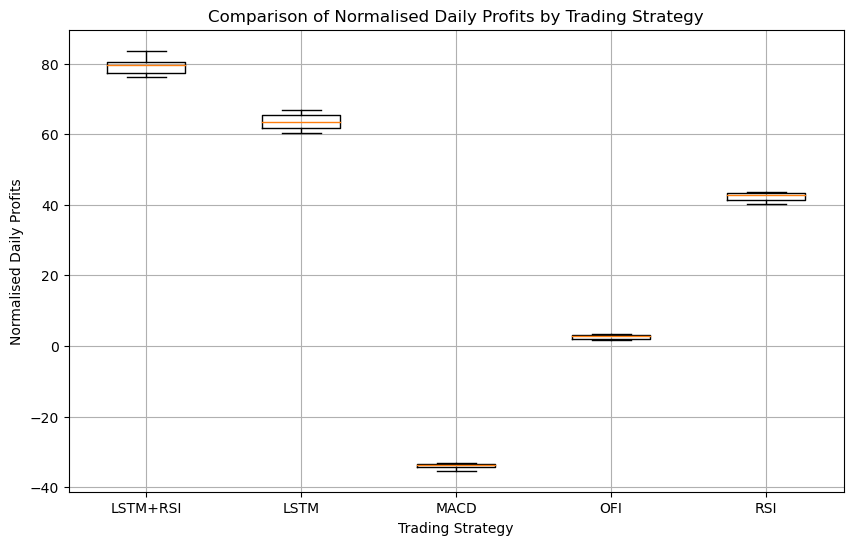

In [49]:
import matplotlib.pyplot as plt

def run_strategy(strategy, sample_set, initial_capital, loaded_pred_adjusted):
    daily_profits = []
    
    for day in range(16, 26):
        start_timestamp = f'2025-06-{day:02d} 00:00:00'
        end_timestamp = f'2025-06-{day:02d} 23:59:59'
        
        daily_data = sample_set[(sample_set['Datetime'] >= start_timestamp) & (sample_set['Datetime'] <= end_timestamp)]
        
        if not daily_data.empty:
            capital = initial_capital
            current_holdings = 0
            trade_log = []

            for i in range(len(daily_data) - 1):
                # Trading logic...
                current_true = daily_data['price'].iloc[i]
                current_predict = loaded_pred_adjusted[i]
                next_predict = loaded_pred_adjusted[i+1]

                # Adjust the trade quantity based on the volatility
                current_volatility_buy = daily_data['Volatility Min Ask'].iloc[i]
                current_volatility_sell = daily_data['Volatility Max Bid'].iloc[i]

                # Get other indicators
                ofi = daily_data['ofi'].iloc[i]
                rsi = daily_data['RSI'].iloc[i]
                macd_signal = daily_data['MACD Trade Signal'].iloc[i]

                if strategy == 'LSTM+RSI':
                    if next_predict >= current_true * 1.2 and rsi < 30:
                        buy_price = current_true
                        buy_quantity = adjust_trade_quantity(current_volatility_buy, daily_data['Min Ask Quantity'].iloc[i], scaler_factor=10)
                        capital -= buy_price * buy_quantity * (1 + transaction_cost)
                        current_holdings += buy_quantity
                        trade_log.append({'action': 'BUY', 'Time': daily_data['Datetime'].iloc[i], 'price': buy_price, 'capital': capital, 'quantity': buy_quantity, 'max quantity': daily_data['Min Ask Quantity'].iloc[i]})
                    elif current_holdings > 0 and next_predict <= current_true * 0.8 and rsi > 70:
                        sell_price = current_true
                        sell_quantity = min(current_holdings, adjust_trade_quantity(current_volatility_sell, daily_data['Max Bid Quantity'].iloc[i], scaler_factor=20))
                        capital += sell_price * sell_quantity * (1 - transaction_cost)
                        current_holdings -= sell_quantity
                        if current_holdings == 0:
                            has_position = False
                        trade_log.append({'action': 'SELL', 'Time': daily_data['Datetime'].iloc[i], 'price': sell_price, 'capital': capital, 'quantity': sell_quantity, 'max quantity': daily_data['Max Bid Quantity'].iloc[i]})
                    else:
                        trade_log.append({'action': 'HOLD', 'Time': daily_data['Datetime'].iloc[i], 'price': current_true, 'capital': capital, 'quantity': current_holdings})
                
                # Add other strategies here with their respective conditions
                elif strategy == 'LSTM':
                    if next_predict >= current_true * 1.2:
                        buy_price = current_true
                        buy_quantity = adjust_trade_quantity(current_volatility_buy, daily_data['Min Ask Quantity'].iloc[i], scaler_factor=10)
                        capital -= buy_price * buy_quantity * (1 + transaction_cost)
                        current_holdings += buy_quantity
                        trade_log.append({'action': 'BUY', 'Time': daily_data['Datetime'].iloc[i], 'price': buy_price, 'capital': capital, 'quantity': buy_quantity, 'max quantity': daily_data['Min Ask Quantity'].iloc[i]})
                    elif current_holdings > 0 and next_predict <= current_true * 0.8:
                        sell_price = current_true
                        sell_quantity = min(current_holdings, adjust_trade_quantity(current_volatility_sell, daily_data['Max Bid Quantity'].iloc[i], scaler_factor=20))
                        capital += sell_price * sell_quantity * (1 - transaction_cost)
                        current_holdings -= sell_quantity
                        if current_holdings == 0:
                            has_position = False
                        trade_log.append({'action': 'SELL', 'Time': daily_data['Datetime'].iloc[i], 'price': sell_price, 'capital': capital, 'quantity': sell_quantity, 'max quantity': daily_data['Max Bid Quantity'].iloc[i]})
                    else:
                        trade_log.append({'action': 'HOLD', 'Time': daily_data['Datetime'].iloc[i], 'price': current_true, 'capital': capital, 'quantity': current_holdings})
                #     ...
                elif strategy == 'MACD':
                    if macd_signal==1:
                        buy_price = current_true
                        buy_quantity = adjust_trade_quantity(current_volatility_buy, daily_data['Min Ask Quantity'].iloc[i], scaler_factor=10)
                        capital -= buy_price * buy_quantity * (1 + transaction_cost)
                        current_holdings += buy_quantity
                        trade_log.append({'action': 'BUY', 'Time': daily_data['Datetime'].iloc[i], 'price': buy_price, 'capital': capital, 'quantity': buy_quantity, 'max quantity': daily_data['Min Ask Quantity'].iloc[i]})
                    elif macd_signal==-1:
                        sell_price = current_true
                        sell_quantity = min(current_holdings, adjust_trade_quantity(current_volatility_sell, daily_data['Max Bid Quantity'].iloc[i], scaler_factor=20))
                        capital += sell_price * sell_quantity * (1 - transaction_cost)
                        current_holdings -= sell_quantity
                        if current_holdings == 0:
                            has_position = False
                        trade_log.append({'action': 'SELL', 'Time': daily_data['Datetime'].iloc[i], 'price': sell_price, 'capital': capital, 'quantity': sell_quantity, 'max quantity': daily_data['Max Bid Quantity'].iloc[i]})
                    else:
                        trade_log.append({'action': 'HOLD', 'Time': daily_data['Datetime'].iloc[i], 'price': current_true, 'capital': capital, 'quantity': current_holdings})
                #     ...
                elif strategy == 'OFI':
                    if ofi > 3:
                        buy_price = current_true
                        buy_quantity = adjust_trade_quantity(current_volatility_buy, daily_data['Min Ask Quantity'].iloc[i], scaler_factor=10)
                        capital -= buy_price * buy_quantity * (1 + transaction_cost)
                        current_holdings += buy_quantity
                        trade_log.append({'action': 'BUY', 'Time': daily_data['Datetime'].iloc[i], 'price': buy_price, 'capital': capital, 'quantity': buy_quantity, 'max quantity': daily_data['Min Ask Quantity'].iloc[i]})
                    elif ofi < -2:
                        sell_price = current_true
                        sell_quantity = min(current_holdings, adjust_trade_quantity(current_volatility_sell, daily_data['Max Bid Quantity'].iloc[i], scaler_factor=20))
                        capital += sell_price * sell_quantity * (1 - transaction_cost)
                        current_holdings -= sell_quantity
                        if current_holdings == 0:
                            has_position = False
                        trade_log.append({'action': 'SELL', 'Time': daily_data['Datetime'].iloc[i], 'price': sell_price, 'capital': capital, 'quantity': sell_quantity, 'max quantity': daily_data['Max Bid Quantity'].iloc[i]})
                    else:
                        trade_log.append({'action': 'HOLD', 'Time': daily_data['Datetime'].iloc[i], 'price': current_true, 'capital': capital, 'quantity': current_holdings})
                #     ...
                elif strategy == 'RSI':
                    if  rsi < 30:
                        buy_price = current_true
                        buy_quantity = adjust_trade_quantity(current_volatility_buy, daily_data['Min Ask Quantity'].iloc[i], scaler_factor=10)
                        capital -= buy_price * buy_quantity * (1 + transaction_cost)
                        current_holdings += buy_quantity
                        trade_log.append({'action': 'BUY', 'Time': daily_data['Datetime'].iloc[i], 'price': buy_price, 'capital': capital, 'quantity': buy_quantity, 'max quantity': daily_data['Min Ask Quantity'].iloc[i]})
                    elif rsi > 70:
                        sell_price = current_true
                        sell_quantity = min(current_holdings, adjust_trade_quantity(current_volatility_sell, daily_data['Max Bid Quantity'].iloc[i], scaler_factor=20))
                        capital += sell_price * sell_quantity * (1 - transaction_cost)
                        current_holdings -= sell_quantity
                        if current_holdings == 0:
                            has_position = False
                        trade_log.append({'action': 'SELL', 'Time': daily_data['Datetime'].iloc[i], 'price': sell_price, 'capital': capital, 'quantity': sell_quantity, 'max quantity': daily_data['Max Bid Quantity'].iloc[i]})
                    else:
                        trade_log.append({'action': 'HOLD', 'Time': daily_data['Datetime'].iloc[i], 'price': current_true, 'capital': capital, 'quantity': current_holdings})
                #     ...

            final_capital = capital
            profit = final_capital - initial_capital
            number_of_buy = len([trade for trade in trade_log if trade['action'] == 'BUY'])
            number_of_sell = len([trade for trade in trade_log if trade['action'] == 'SELL'])
            daily_profits.append(profit / (number_of_buy + number_of_sell))
    
    return daily_profits

# Initialize a dictionary to store daily profits for each strategy
strategy_daily_profits = {}

# Run each strategy and store its daily profits
strategies = ['LSTM+RSI', 'LSTM', 'MACD', 'OFI', 'RSI']
for strategy in strategies:
    daily_profits = run_strategy(strategy, sample_set, initial_capital, loaded_pred_adjusted)
    strategy_daily_profits[strategy] = daily_profits

# Plot the results
plt.figure(figsize=(10, 6))
plt.boxplot(strategy_daily_profits.values(), labels=strategy_daily_profits.keys())
plt.title('Comparison of Normalised Daily Profits by Trading Strategy')
plt.xlabel('Trading Strategy')
plt.ylabel('Normalised Daily Profits')
plt.grid(True)
plt.show()


## EXP1 Only use LSTM prediction
buy: next price > current price * 1.2 
sell: next price < current price * 0.8

Profit:  300765
Normalised daily profits (profits divided by number of trades in that day) 68.65
Number of buys:  2675
Number of sells:  1706
Number of holds:  26056


## EXP2 Only use LSTM prediction
buy: next price > current price * 1.5
sell: next price < current price * 0.7

Profit:  106871
Normalised daily profits (profits divided by number of trades in that day) 71.49
Number of buys:  945
Number of sells:  550
Number of holds:  28942


## EXP3  Only use MACD signal
fast ema： 20； slow ema： 40； signal： 10
buy: macd_signal == 1
sell: macd_signal == -1

Profit:  -97602
Normalised daily profits (profits divided by number of trades in that day) -35.36
Number of buys:  1380
Number of sells:  1380
Number of holds:  27677

## EXP4  Only use OFI
buy: ofi > 3
sell: ofi < -2

Profit:  40230
Normalised daily profits (profits divided by number of trades in that day) 3.45
Number of buys:  7688
Number of sells:  3986
Number of holds:  18763

## EXP5  Only use RSI
buy: rsi < 30, RSI values below 30 usually indicate that the market may be oversold, which may be a signal to buy.
sell: rsi > 70, RSI values above 70 usually indicate that the market may be overbought, which may be a signal to sell.
(Already tried several combinations, this one get the best normalised daily profits)

Profit:  777902
Normalised daily profits (profits divided by number of trades in that day) 43.58
Number of buys:  12168
Number of sells:  5683
Number of holds:  12586

## EXP6  Use LSTM prediction and RSI
buy: next price > current price * 1.2 and rsi < 30
sell: next price < current price * 0.8 and rsi > 70

Profit:  266469
Normalised daily profits (profits divided by number of trades in that day) 98.77
Number of buys:  1440
Number of sells:  1258
Number of holds:  27739